# Week 4 Lab: You are what you eat (differential expression)

**Due: Monday 4/29/19 11:59pm**

**Partner:** (optional)

Use this notebook to report your findings from the lab. Lab reports typically should include:
* An introduction giving motivation behind the study, what was done, and summarizing the main findings.
* A methods section providing details on how the analyses were performed.
* A results section providing the main findings.
* A discussion section with interpretation of the results and some leads for future directions.

For this report, we will focus on Methods, Results, and Discussion and have provided some prompts below for these. We have provided an example introduction this week as a reference for future weeks.

**Notes on how to complete the lab report**:

Short answer questions should use Markdown syntax (http://nestacms.com/docs/creating-content/markdown-cheat-sheet). If you would like to include an answer that is a mixture of code and text, you can generate additional cells below the provided answer cell.

You may include Python code to directly generate tables (this can be much easier than copying the numbers to markdown syntax from scratch).

For questions that ask for plots, we prefer you include Python code to generate the results inline. However if you really want to you may also include figures using other means (e.g. making them separately and linking to them in the markdown. or making them in R).

## Introduction

An introduction should provide:
* motivation for the study
* a brief summary of what was done
* a brief summary of the major results

Diet-induced obesity is known to be a major factor leading to increased risk for a variety of conditions such as heart disease and diabetes. Multiple studies have suggested that diets high in fat content may be contributing to the growing prevalence of obesity and related conditions.

In this study, RNA-sequencing was performed on livers of mice after being fed either a standard Chow diet or a high fat diet (HFD) for seven weeks. We performed differential expression analysis to identify and characterize genes with increased or decreased activity induced by each diet. Overall, we found hundreds of genes showed altered expression levels in the HFD group, suggesting significant diet-induced reprogramming of liver transcription. Differentially expressed genes are highly enriched for involvement in metabolic processes such as lipid processing.

# Methods (20 pts total)

**Dataset description (<font color="red">Methods-Q1</font> - 5 pts)**: Provide a brief description of the six datasets used, including:
* How many samples are you analyzing and where did they come from? (e.g. what species are they, what tissue are you analyzing, what is the difference between the two treatment groups?)
* The number of reads for each sample (i.e. from the original fastqs)
* The read length

The six datasets that are used for this anaylsis consist of mice transcriptomes (RNA-seq data) from two different classes with all samples being drawn from liver tissue biopsies. There are three samples from each class, with the two classes being mice with a high fat diet (HFD) and mice with a standard "chow" diet. The analysis is done to see how gene expression levels vary in mice with different diets and how those genes might be up or down regulated to cope with the different circumstances. 

The data for each sample consists of fastq files that contain the RNA sequence data of each mouse sample. The exact details of each fastq are listed as (analysis done with command line tools and verified with fastqc):

Chow_Rep1.fq

read length: 50, number of reads: 70123120/4 = 17530780

Chow_Rep2.fq

read length: 50, number of reads: 70340660/4 = 17585165

Chow_Rep3.fq

read length: 50, number of reads: 64088296/4 = 16022074

HFD_Rep1.fq

read length: 50, number of reads: 64562596/4 = 16140649

HFD_Rep2.fq

read length: 50, number of reads: 60862004/4 = 15215501

HFD_Rep3.fq

read length: 50, number of reads: 45252364/4 = 11313091

**Alignment and expression quantification (<font color="red">Methods-Q2</font> - 5 pts)**: Summarize the methods used for aligning RNA-seq reads and quantifying expression for each sample. Include:
* Which tools you used (and ideally which version of each tool)
* Which assembly of the reference genome was used?
* Which transcriptome annotation was used?
* Any non-default parameters used for each tool.

Following along the typical sequence method pipeline, the first thing to do with the fragmented reads in the fastq file is to align them to a reference genome. In this case since our reads are RNA fragments we are aligning to a reference trascriptome. This is simply the coding regions of the reference genome taking into account for the spliced introns and coding exons. This is done with a program called STAR. STAR 2.7.0d is used (STAR --help | grep 'version'). STAR takes in the fastq files (containing the RNA reads) along with the reference transcriptome and outputs two BAM files. One for alignment to the original mouse reference genome and one for the reference transcriptome. For this specific application the inputs are the GRCm38.fa reference along with the GRCm38.75.gtf gene annotation file (ENSEMBL build 75). The annotation file indicates the locations on the genome of exon regions such as the start and end boundaries. STAR is first used to create an index file used to easily locate regions when aligning. The index file is then used to align the reads to the reference. The indexing command follows the standard parameters indicated in the manual however the alignment command uses specific parameters recommended by ENCODE. These include the following:

STAROPTS="--outSAMattributes NH HI AS NM MD \ <br>
    --outFilterType BySJout \ <br>
    --outFilterMultimapNmax 20 \ <br>
    --outFilterMismatchNmax 999 \ <br>
    --outFilterMismatchNoverReadLmax 0.04 \ <br>
    --alignIntronMin 20 \ <br>
    --alignIntronMax 1000000 \ <br>
    --alignMatesGapMax 1000000 \ <br>
    --alignSJoverhangMin 8 \ <br>
    --alignSJDBoverhangMin 1 \ <br>
    --sjdbScore 1 \ <br>
    --limitBAMsortRAM 50000000000" <br>

Typically the basic mapping options only include the number of threads, the genome directory and the files in.

Next, RSEM (Current version: RSEM v1.3.1) is used for quantifying the gene expression from RNA-seq. This takes in the BAM file that is aligned to the transcriptome which was generated from STAR. In addition RSEM also needs to prepare the reference transcriptome by taking in the reference genome and gene annotation. Quantification is then calculated by running rsem-calculate-expression with indicated fields. In the command given in the instruction notebook it is run with the option -p 5 (indicates the number of threads). The output of RSEM is a .results file and there is one for total gene expression results as well as one for gene isoform results. 

**Differential expression analysis (<font color="red">Methods-Q3</font> - 5 pts)**: Summarize the methods used for performing differential expression analysis:

* Which tool(s) did you use for this?
* What preprocessing did you to do the data before running (e.g. loaded with tximport, removed lowly expressed genes)
* What significance value did you use to decide which genes are differentially expressed?

(Note, using the R command `sessionInfo()` will tell you which versions of each package are loaded).

In order to conduct the differential expression analysis the DESeq2 library is used in R. Specifically we are using DESeq2 version DESeq2_1.22.2. Further more the tximport library (tximport_1.10.1) is also used in order to load the RSEM results. The analysis is run in a Jupyter notebook magic cell (enabled to run R %%R), then the tximport loads the data into the worksapce and then a pseudocount of 1 is used to replace all values that are 0 (I believe this is for computing log values). Then counts less than 10 are removed since they are so low and unlikely to be differentially expressed. A significance value threshold of 0.05 is used or 5% since those most likely account for the the false discovery rates. The data is then pipped to the deseq2 function. The outputof the function is then sent to chow_vs_hfd_deseq2.csv.

**Gene enrichment analysis methods (<font color="red">Methods-Q4</font> - 5 pts)**: Summarize the methods you used for performing GO analysis on your differentially expressed genes. (Don't worry if you can't figure out the version of `find_enrichment.py`).

The script find_enrichment.py is used to categorize the genes into their selected ontology groups. This script comes from the Python package goatools. First one defines 'background' as all genes that were analyzed and then 'foreground' are the genes that are considered differentially expressed. The inputs into this script are as follows:

* a file containing a list of gene names of differentially expressed genes
* a file containing a list of gene names of all analyzed genes
* a file mapping each gene to its annotated GO categories. We have provided this in the `week4/GOAnalysis/` folder
* a file containing the GO database. It is also provided in the `week4/GOAnalysis/` folder.

In order to get the first two files, the results from the differentaily expressed genes are outputted into text files for this command. The command is run twice, first using statistically significant differentially expressed up regulated genes as the foreground and then another time with statistically significant differentially expressed down regulated genes. The output files can then be parsed for the significant ontology groupings ranking by p value.

# Results (45 pts total)

## Summary of expression quantification

**How many genes were expressed (TPM>0) in each sample? (<font color="red">Results-Q1</font> - 3 pts)**

Using the command:

cut -f6Chow_Rep1.genes.results | awk '(NR>1 && $1>0)' | wc -l

for each output file from RSEM the following results for TPM>0 is:

Chow_Rep1.fq = 16912 genes

Chow_Rep2.fq = 17091 genes

Chow_Rep3.fq = 16790 genes

HFD_Rep1.fq = 17073 genes

HFD_Rep2.fq = 16843 genes

HFD_Rep3.fq = 16730 genes

**Report the pairwise Pearson correlation between TPM values for each of the six samples (<font color="red">Results-Q2</font> - 5 pts)**: Are replicates strongly correlated with each other? Are replicates of Chow or HFD more strongly correlated than datasets from different treatments (Chow vs. HFD)?

In [2]:
# Run this to allow plotting in the notebook
%pylab inline

# Run this to allow using the %%R cell magic
%load_ext rpy2.ipython

# Suppress warnings (most notable from rpy2)
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
%pylab inline
import os
import pandas as pd
import scipy.stats
OUTDIR="/datasets/cs185s-sp19-public/week4/precomputed/"

# Load data for each sample into a pandas data frame
prefixes = ["Chow_Rep1","Chow_Rep2","Chow_Rep3","HFD_Rep1","HFD_Rep2","HFD_Rep3"]
data = pd.read_csv(os.path.join(OUTDIR, "%s.genes.results"%prefixes[0]), sep="\t")
data = data[["gene_id", "TPM"]]
data.columns = ["gene_id", prefixes[0]]
for i in range(1, len(prefixes)):
    d = pd.read_csv(os.path.join(OUTDIR, "%s.genes.results"%prefixes[i]), sep="\t")
    d = d[["gene_id","TPM"]]
    d.columns = ["gene_id", prefixes[i]]
    data = pd.merge(data, d, on=["gene_id"])
    
# For each sample, take log10 TPM and add a pseudocount of 1 to avoid 0s
for p in prefixes: data[p] = np.log10(data[p]+1)
    
(data[prefixes].corr())

Populating the interactive namespace from numpy and matplotlib


,Chow_Rep1,Chow_Rep2,Chow_Rep3,HFD_Rep1,HFD_Rep2,HFD_Rep3
Chow_Rep1,1.000000,0.984319,0.984712,0.980339,0.983259,0.983136
Chow_Rep2,0.984319,1.000000,0.988975,0.986150,0.985107,0.981766
Chow_Rep3,0.984712,0.988975,1.000000,0.985333,0.985238,0.981117
HFD_Rep1,0.980339,0.986150,0.985333,1.000000,0.987234,0.982590
HFD_Rep2,0.983259,0.985107,0.985238,0.987234,1.000000,0.984152
HFD_Rep3,0.983136,0.981766,0.981117,0.982590,0.984152,1.000000


Correlation values are actually pretty similar across all samples and datasets. There is only ever a change of at max 0.007 between chow and HFD mice. The results are shown in the correlation matrix shown above. The matrix is a diagonal and symmetric matrix where diagonal terms are compared against themselvse hence why they are 1 and the off diagonal terms are the comparison between corresponding row and column pairs. 

**Comparison of replicates (<font color="red">Results-Q3</font> - 7 pts):**  Provide a scatter plot of gene expression values (TPM) in Chow replicates 1 vs. 2 and HFD replicates 1 vs. 2. 

Text(0,0.5,'log10 HFD_Rep2')

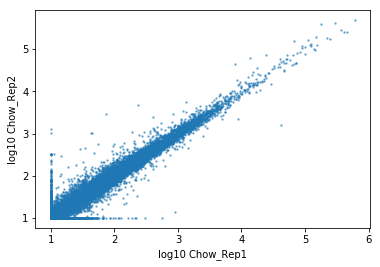

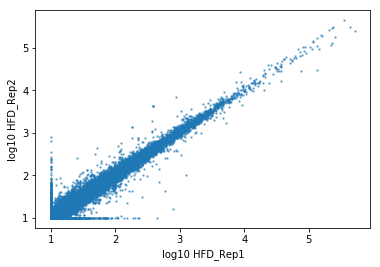

In [4]:
   
# Correlation scatter plots
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ax.scatter((data["Chow_Rep1"]+1), (data["Chow_Rep2"]+1), s=2, alpha=0.5)
ax.set_xlabel("log10 Chow_Rep1")
ax.set_ylabel("log10 Chow_Rep2")

fig2 = plt.figure()
fig2.set_size_inches((6, 4))
ax2 = fig2.add_subplot(111)
ax2.scatter((data["HFD_Rep1"]+1), (data["HFD_Rep2"]+1), s=2, alpha=0.5)
ax2.set_xlabel("log10 HFD_Rep1")
ax2.set_ylabel("log10 HFD_Rep2")

## Summary of differential gene expression

**Visualization of differentially expressed genes (<font color="red">Results-Q4</font> - 10 pts)**: Provide a "volcano plot" plotting the log2 fold change in gene expression vs. the -log10 p-value for each gene. Color significant genes (FDR<0.05) a different color.

*Extra credit (3 pts)*: Annotate the names of the top 10 differentially expressed genes on the plot. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

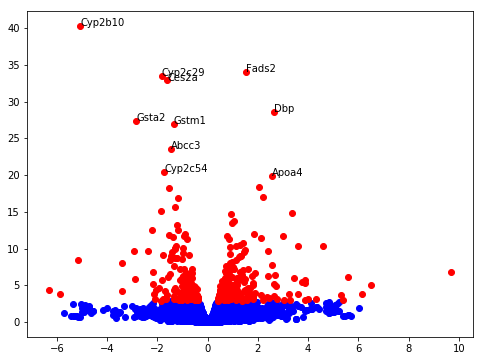

In [148]:
data = pd.read_csv('../week4/chow_vs_hfd_deseq2.csv',usecols=[0,2,5,6])
gene_names = pd.read_csv('/datasets/cs185s-sp19-public/week4/GRCm38.75.gene_names',header=None,sep='\t',index_col=0)
fig = plt.figure()
fig.set_size_inches((8, 6))
ax = fig.add_subplot(111)
data['pvalue'] = -np.log10(data['pvalue'])

mask = data['padj']>=0.05
mask2 = data['padj']<0.05

ax.scatter(data[mask]['log2FoldChange'],data[mask]['pvalue'],color='blue')
ax.scatter(data[mask2]['log2FoldChange'],data[mask2]['pvalue'],color='red')


number_top_genes = 10
data_sorted=data.sort_values('pvalue',ascending=False)
data_sorted.set_index('Unnamed: 0',inplace=True)

#Annotation
genes = []
for i in range(number_top_genes):
    name = gene_names.loc[data_sorted.index[i]].iloc[0]
    genes.append(name)
    ax.annotate(name,(data_sorted['log2FoldChange'].iloc[i],data_sorted['pvalue'].iloc[i]))

**Differential expression results (<font color="red">Results-Q5</font> - 10 pts)** How many total genes were differentially expressed at an adjusted p-value threshold of 0.05? Provide a table of the top 10 differentially expressed genes. The table should report gene names (not IDs), the log2 fold change, and the p-value for each gene.

In [149]:
total_num = len(data[mask2])
print("Total number of genes differentially expressed:",total_num)

top = data_sorted.head(n=10)
top.index=genes
top['pvalue'] = 10**(-top['pvalue'])
top[['log2FoldChange','pvalue']]

Total number of genes differentially expressed: 375


,log2FoldChange,pvalue
Cyp2b10,-5.083951,4.424623e-41
Fads2,1.545719,9.952204e-35
Cyp2c29,-1.835318,3.565345e-34
Ces2a,-1.600727,1.280916e-33
Dbp,2.637427,2.367820e-29
Gsta2,-2.837015,4.808465e-28
Gstm1,-1.360523,1.148110e-27
Abcc3,-1.457844,2.788198e-24
Cyp2c54,-1.732744,4.001637e-21
Apoa4,2.544864,1.192791e-20


## Gene ontology enrichment analysis

**GO results (<font color="red">Results-Q6</font> - 10 pts)**: Provide a list of the top 10 enriched GO categories each in down- and up- regulated genes (so two lists of 10 categories), ranked by p-value. For each enriched category, provide at least the name of the category and its enrichment p-value.

In [18]:
data = pd.read_csv('../week4/chow_vs_hfd_deseq2.csv',usecols=[0,2,5,6])
gene_names = pd.read_csv('/datasets/cs185s-sp19-public/week4/GRCm38.75.gene_names',header=None,sep='\t',index_col=0)
data['pvalue'] = -np.log10(data['pvalue'])

data_sorted=data.sort_values('pvalue',ascending=False)
data_sorted.set_index('Unnamed: 0',inplace=True)
mask = data_sorted['padj']<0.05

#differentially expressed genes
DE = data_sorted[mask]

up_mask = DE['log2FoldChange']>0
down_mask = DE['log2FoldChange']<0

up = DE[up_mask]
down = DE[down_mask]

#gene names
up_genes = []
down_genes = []
all_genes = []

for i in range(len(up)):
    name = gene_names.loc[up.index[i]].iloc[0]
    up_genes.append(name)

for i in range(len(down)):
    name = gene_names.loc[down.index[i]].iloc[0]
    down_genes.append(name)
    
for i in range(len(data_sorted)):
    name = gene_names.loc[data_sorted.index[i]].iloc[0]
    all_genes.append(name)

In [19]:
with open('../week4/up_genes.txt', 'w') as f:
    for item in up_genes:
        f.write("%s\n" % item)
f.close()
        
with open('../week4/down_genes.txt', 'w') as f:
    for item in down_genes:
        f.write("%s\n" % item)
f.close()

with open('../week4/all_genes.txt', 'w') as f:
    for item in all_genes:
        f.write("%s\n" % item)
f.close()

The run the commands:

find_enrichment.py up_genes.txt all_genes.txt /datasets/cs185s-sp19-public/week4/GOAnalysis/mgi.assoc --obo /datasets/cs185s-sp19-public/week4/GOAnalysis/go-basic.obo --outfile=up_genes.xlsx,up_genes.tsv --method=fdr_bh --alpha=0.01


find_enrichment.py down_genes.txt all_genes.txt /datasets/cs185s-sp19-public/week4/GOAnalysis/mgi.assoc --obo /datasets/cs185s-sp19-public/week4/GOAnalysis/go-basic.obo --outfile=down_genes.xlsx,down_genes.tsv --method=fdr_bh --alpha=0.01

Then we can import the go analysis files into python and sort the categories by p value.

 Provide a list of the top 10 enriched GO categories each in down- and up- regulated genes (so two lists of 10 categories), ranked by p-value. For each enriched category, provide at least the name of the category and its enrichment p-value.

In [20]:
up_go = pd.read_csv('../week4/up_genes.tsv',sep='\t')
down_go = pd.read_csv('../week4/down_genes.tsv',sep='\t')

up_go.sort_values('p_uncorrected').head(10)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0044283,BP,e,small molecule biosynthetic process,41/196,373/15423,6.591399e-27,3,41,1.358158e-22,"Abhd2, Acaca, Acacb, Acly, Acot11, Acsl3, Apoa..."
1,GO:0008610,BP,e,lipid biosynthetic process,35/196,338/15423,4.033259e-22,4,35,4.155265e-18,"Abhd2, Acaca, Acacb, Acly, Acot11, Acsl3, Apoa..."
2,GO:0006629,BP,e,lipid metabolic process,51/196,827/15423,8.919540e-22,3,51,6.126237e-18,"Aacs, Abhd2, Acaca, Acacb, Acly, Acot11, Acsl3..."
3,GO:0044281,BP,e,small molecule metabolic process,60/196,1190/15423,2.569029e-21,2,60,1.323371e-17,"Aacs, Abhd2, Acaca, Acacb, Acly, Acmsd, Acot11..."
4,GO:0016126,BP,e,sterol biosynthetic process,14/196,33/15423,1.188656e-18,6,14,4.898453e-15,"Apoa4, Cyb5r3, Cyp51, Dhcr24, Dhcr7, Fdft1, Fd..."
5,GO:0072330,BP,e,monocarboxylic acid biosynthetic process,20/196,113/15423,1.281994e-17,7,20,3.855047e-14,"Abhd2, Acaca, Acacb, Acly, Acot11, Acsl3, Asns..."
6,GO:1902653,BP,e,secondary alcohol biosynthetic process,13/196,30/15423,1.496742e-17,6,13,3.855047e-14,"Apoa4, Cyb5r3, Cyp51, Dhcr24, Dhcr7, Fdft1, Fd..."
7,GO:0006695,BP,e,cholesterol biosynthetic process,13/196,30/15423,1.496742e-17,7,13,3.855047e-14,"Apoa4, Cyb5r3, Cyp51, Dhcr24, Dhcr7, Fdft1, Fd..."
8,GO:0008203,BP,e,cholesterol metabolic process,18/196,94/15423,1.315827e-16,6,18,3.012513e-13,"Apoa4, Cyb5r3, Cyp51, Cyp7a1, Dhcr24, Dhcr7, E..."
9,GO:0046394,BP,e,carboxylic acid biosynthetic process,23/196,192/15423,3.371854e-16,6,23,6.947705e-13,"Abhd2, Acaca, Acacb, Acly, Acot11, Acsl3, Asns..."


In [21]:
down_go.sort_values('p_uncorrected').head(10)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items
0,GO:0006805,BP,e,xenobiotic metabolic process,17/179,83/15423,6.104662e-17,3,17,1.024100e-12,"Acaa1b, Acsl1, Cdo1, Csad, Cyp1a2, Cyp26a1, Cy..."
46,GO:0004497,MF,e,monooxygenase activity,18/179,101/15423,9.940305e-17,3,18,1.024100e-12,"Cyp1a2, Cyp26a1, Cyp2b10, Cyp2c29, Cyp2c37, Cy..."
47,GO:0008391,MF,e,arachidonic acid monooxygenase activity,11/179,30/15423,1.704104e-14,4,11,1.170435e-10,"Cyp2b10, Cyp2c29, Cyp2c37, Cyp2c50, Cyp2c54, C..."
48,GO:0005506,MF,e,iron ion binding,17/179,119/15423,3.406377e-14,6,17,1.754710e-10,"Aox1, Cdo1, Cyp1a2, Cyp26a1, Cyp2b10, Cyp2c29,..."
49,GO:0016705,MF,e,"oxidoreductase activity, acting on paired dono...",18/179,150/15423,1.303316e-13,3,18,5.370964e-10,"Cyp1a2, Cyp26a1, Cyp2b10, Cyp2c29, Cyp2c37, Cy..."
1,GO:0006082,BP,e,organic acid metabolic process,35/179,706/15423,2.198350e-13,3,35,7.211450e-10,"Acaa1b, Acot1, Acox2, Acsl1, Afmid, Cdo1, Ces1..."
50,GO:0008392,MF,e,arachidonic acid epoxygenase activity,10/179,27/15423,2.449898e-13,5,10,7.211450e-10,"Cyp2b10, Cyp2c29, Cyp2c37, Cyp2c50, Cyp2c54, C..."
51,GO:0004364,MF,e,glutathione transferase activity,10/179,29/15423,5.701385e-13,4,10,1.468463e-09,"Gsta1, Gsta2, Gsta4, Gstm1, Gstm3, Gstm4, Gstm..."
52,GO:0070330,MF,e,aromatase activity,10/179,30/15423,8.466872e-13,5,10,1.783005e-09,"Cyp1a2, Cyp2b10, Cyp2c29, Cyp2c37, Cyp2c50, Cy..."
2,GO:0019752,BP,e,carboxylic acid metabolic process,33/179,658/15423,8.653266e-13,5,33,1.783005e-09,"Acaa1b, Acot1, Acox2, Acsl1, Afmid, Cdo1, Ces1..."


# Discussion (15 pts total)

**<font color="red">Discussion-Q1</font> - 5 pts**: Summarize the characteristics of genes that are up- and down-regulated in HFD compared to Chow fed mice. Do the GO categories enriched in those gene sets make sense? Do a little exploring of the top misregulated genes to find out what they might be doing.

The results based on GO analysis and categorization make sense in what we would expect to see when comparing gene expression from 'chow' mice to HFD mice. The top categories from the up regulated genes include groups dealing with lipid biosynthetic and metabolic processes. Furthermore there are also groups involving cholestrol biosynthetic and metabolic processes. This makes sense because in the HFD mice you would expect more activity is directed toward dealing with the higher fat content in their diet. This is seen in the higher expression of genes involving those processes. The down regulated analysis is a a bit trickier to do but it seems that there is less regulation of genes involving the metabolism or breakdown of xenobiotics. These can be grouped as carcinogens, drugs, environmental pollutants, food additives, hydrocarbons, and pesticides. This makes sense in that the chow diet may have other types of chemicals or pesticides that need to be broken down.

**<font color="red">Discussion-Q2</font> - 5 pts**: You'll likely notice from your volcano plot that there are many genes with very high fold changes (e.g. log2 fold change > 6) but that are not called as significant. Hypothesize why. it could be helpful to dig in and look at the data for some of those genes.

Fold change can tend to be not too indicative of biological effect since small changes in some genes can have drastic effects when comapred to others. The genes that have large fold change but low significance means that the values do not differ very much if the values were gather from random experiments. This means that those genes tend to have larger variability in general. This means that when doing random tests, the values that you would expect to see come from a larger varying distribution and hence it is normal to see values with large swings. It would take a lot larger fold change than what is seen in order for the significance of the gene to increase.

**<font color="red">Discussion-Q3</font> - 5 pts**: For GO analysis, the choice of the background set of genes can be important. Here, we chose the set of all genes we analyzed with DESeq2 as the background. This ensured that we were only looking at genes that were at least somewhat expressed in liver in at least one of our samples. We could have instead chosen a different background set, such as all mouse genes. Hypothesize how this might have changed our results?

Changing what the background set of genes will greatly affect the results of the GO analysis. Since choosing groups and categorizing depends on the difference from what qunaitity of a gene is seen in a sample compared to if just random samples were taken from all background genes. Including more genes, such as ones not even seen in the sample, will greatly influence those ratios needed for determining significance. Using tissue specific bacground genes will add a bias into what is considered differentially expressed since different tiusses can be expected to have different expressions. Hence it would be normal to see larger quantity of a tissue specific gene. If this were the case anywhere else in the body, thise gene would be considered significantly expressed because ratios of categories will be similar (more normalized) and hence the higher concentration found in a specific tissue will be a lot greater. Using the whole mouse genome as the background as proposed may increase the significance of tissue specific genes. This will muddle the results of the actual biological processes that we are actually trying to see.